TP4 — Confiance Numérique et accès biométrique (Version 4.0)

In [ ]:
# %% [markdown]
# # TP4 — Confiance Numérique et accès biométrique (Version 3.0)
# ## Extraction biométrique avancée avec sécurisation cryptographique
# 
# **Améliorations V3 :**
# - Implémentation complète Fuzzy Vault (sans dépendance cryptography)
# - Implémentation complète Fuzzy Extractor
# - Détection réelle de minuties pour empreintes
# - MFCC avec deltas et prétraitement audio avancé
# - MediaPipe FaceMesh avec normalisation géométrique
# - Validation et visualisations avancées
# - Conformité RGPD/CNDP renforcée

# %%
# ========== CONFIGURATION INITIALE ==========
import os
import sys
import math
import logging
import warnings
import json
import hashlib
import secrets
import base64
from pathlib import Path
from datetime import datetime
from typing import Optional, Tuple, List, Dict, Any
from dataclasses import dataclass

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, euclidean
from scipy import signal
import scipy.fft as fft

warnings.filterwarnings('ignore')

# Configuration logging
logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('biometric_processing_v4.log', encoding='utf-8'),
        logging.StreamHandler()
    ]
)

# ========== GESTION DES DÉPENDANCES ==========
print("Vérification des dépendances...")

# Variable globale pour MediaPipe
MEDIAPIPE_AVAILABLE = False
try:
    import mediapipe as mp
    mp_face_mesh = mp.solutions.face_mesh
    MEDIAPIPE_AVAILABLE = True
    print("✓ MediaPipe disponible")
except ImportError:
    print("✗ MediaPipe non disponible (fallback sur Haar Cascade)")

# Variable globale pour Librosa
LIBROSA_AVAILABLE = False
try:
    import librosa
    import librosa.display
    LIBROSA_AVAILABLE = True
    print("✓ Librosa disponible")
except ImportError:
    print("✗ Librosa non disponible (extraction audio basique)")
    try:
        import soundfile as sf
        print("✓ SoundFile disponible pour audio basique")
        AUDIO_AVAILABLE = True
    except ImportError:
        AUDIO_AVAILABLE = False
        print("✗ Aucune bibliothèque audio disponible")

# ========== CONFIGURATION SYSTÈME ==========
CONFIG = {
    "face_landmarks": 468,
    "finger_keypoints": 500,
    "audio_sr": 22050,
    "audio_mfcc": 20,
    "min_quality_threshold": 0.3,
    "anonymize_filenames": True,
    "log_processing": True,
    "fuzzy_vault_chaff_ratio": 10,
    "fuzzy_extractor_key_length": 256
}

# Chemins
BASE_DIR = Path('.').resolve()
DATA_DIR = BASE_DIR / 'data'
FACES_DIR = DATA_DIR / 'faces'
FINGER_DIR = DATA_DIR / 'fingerprint'
VOICES_DIR = DATA_DIR / 'voices'
OUTPUTS_DIR = BASE_DIR / 'outputs'
SECURED_DIR = OUTPUTS_DIR / 'secured'

# Création des dossiers
for folder in [FACES_DIR, FINGER_DIR, VOICES_DIR, OUTPUTS_DIR, SECURED_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

print(f"\nDossiers créés/prêts:")
print(f"  Visages: {FACES_DIR}")
print(f"  Empreintes: {FINGER_DIR}")
print(f"  Voix: {VOICES_DIR}")
print(f"  Sortie: {OUTPUTS_DIR}")

# %% [markdown]
# ## 1. Modules Cryptographiques : Fuzzy Vault & Extractor

# %%
@dataclass
class FuzzyVaultConfig:
    """Configuration du Fuzzy Vault"""
    secret_length: int = 128  # bits
    polynomial_degree: int = 8
    chaff_ratio: float = CONFIG["fuzzy_vault_chaff_ratio"]
    match_threshold: float = 0.8
    quantization_levels: int = 1000
    error_tolerance: int = 5

class SimpleHKDF:
    """Implémentation simplifiée de HKDF sans dépendance cryptography"""
    
    @staticmethod
    def derive(key_material: bytes, length: int, salt: bytes = None, info: bytes = None) -> bytes:
        """HKDF simplifié utilisant uniquement hashlib"""
        if salt is None:
            salt = b'\x00' * 32
        
        # Extract
        prk = hashlib.sha256(salt + key_material).digest()
        
        # Expand
        t = b""
        output = b""
        iterations = (length + 31) // 32
        
        for i in range(1, iterations + 1):
            data = t + (info or b"") + bytes([i])
            t = hashlib.sha256(prk + data).digest()
            output += t
        
        return output[:length]

class FuzzyVault:
    """
    Coffre-fort flou pour protection cryptographique des templates biométriques
    Version simplifiée sans dépendance cryptography
    """
    
    def __init__(self, config: Optional[FuzzyVaultConfig] = None):
        self.config = config or FuzzyVaultConfig()
    
    def _quantize_features(self, features: np.ndarray) -> np.ndarray:
        """Quantifie les features continues"""
        if len(features) == 0:
            return np.array([], dtype=int)
        
        features = np.array(features, dtype=float)
        feat_min, feat_max = features.min(), features.max()
        
        if feat_max - feat_min > 1e-10:  # Éviter division par zéro
            normalized = (features - feat_min) / (feat_max - feat_min)
        else:
            normalized = np.zeros_like(features)
        
        quantized = (normalized * (self.config.quantization_levels - 1)).astype(int)
        return quantized
    
    def _secret_to_polynomial(self, secret: bytes) -> np.ndarray:
        """Encode le secret dans un polynôme"""
        # Utilise notre HKDF simplifié
        hkdf = SimpleHKDF()
        key_material = hkdf.derive(secret, self.config.polynomial_degree + 1)
        
        # Convertir en coefficients
        coeffs = []
        for i in range(self.config.polynomial_degree + 1):
            chunk = key_material[i*4:(i+1)*4] if (i+1)*4 <= len(key_material) else key_material[i*4:]
            coeff = int.from_bytes(chunk, 'big', signed=False) % 1000
            coeffs.append(coeff)
        
        return np.array(coeffs, dtype=np.int64)
    
    def _evaluate_polynomial(self, coeffs: np.ndarray, x: int) -> int:
        """Évalue le polynôme en x (modulo quantization_levels)"""
        result = 0
        for i, coeff in enumerate(coeffs):
            result += coeff * (x ** i)
        return result % self.config.quantization_levels
    
    def _generate_chaff_points(self, genuine_points: np.ndarray, n_chaff: int) -> np.ndarray:
        """Génère des points de bruit (chaff points)"""
        if len(genuine_points) == 0:
            return np.array([])
            
        x_coords = genuine_points[:, 0]
        x_min, x_max = x_coords.min(), x_coords.max()
        
        chaff_points = []
        attempts = 0
        max_attempts = n_chaff * 10
        
        while len(chaff_points) < n_chaff and attempts < max_attempts:
            x = np.random.randint(max(0, x_min-10), min(self.config.quantization_levels, x_max+11))
            y = np.random.randint(0, self.config.quantization_levels)
            
            # Vérifier qu'il n'est pas trop proche d'un point genuine
            too_close = False
            for gx, gy in genuine_points:
                if abs(x - gx) <= self.config.error_tolerance and abs(y - gy) <= self.config.error_tolerance:
                    too_close = True
                    break
            
            if not too_close:
                chaff_points.append([x, y])
            
            attempts += 1
        
        return np.array(chaff_points[:n_chaff]) if chaff_points else np.array([])
    
    def lock(self, features: np.ndarray, secret: Optional[bytes] = None) -> Tuple[np.ndarray, bytes, bytes]:
        """Verrouille un secret avec les features biométriques"""
        if secret is None:
            secret = secrets.token_bytes(self.config.secret_length // 8)
        
        # Quantification
        quantized = self._quantize_features(features)
        
        if len(quantized) == 0:
            raise ValueError("Aucune feature à quantifier")
        
        # Génération du polynôme
        poly_coeffs = self._secret_to_polynomial(secret)
        
        # Création des genuine points
        genuine_points = []
        n_points = min(50, len(quantized))
        
        if len(quantized) > 0:
            selected_indices = np.random.choice(len(quantized), min(n_points, len(quantized)), replace=False)
            for idx in selected_indices:
                x = quantized[idx]
                y = self._evaluate_polynomial(poly_coeffs, x)
                genuine_points.append([x, y])
        
        genuine_points = np.array(genuine_points, dtype=np.int64) if genuine_points else np.array([])
        
        # Génération des chaff points
        n_chaff = int(len(genuine_points) * self.config.chaff_ratio) if len(genuine_points) > 0 else 10
        chaff_points = self._generate_chaff_points(genuine_points, n_chaff)
        
        # Construction du vault
        if len(genuine_points) > 0:
            if len(chaff_points) > 0:
                vault_points = np.vstack([genuine_points, chaff_points])
            else:
                vault_points = genuine_points
            np.random.shuffle(vault_points)
        else:
            vault_points = np.array([])
        
        # Hash de vérification
        verification_data = secret + poly_coeffs.tobytes()
        verification_hash = hashlib.sha256(verification_data).digest()
        
        logging.info(f"[Fuzzy Vault] Coffre créé: {len(vault_points)} points")
        
        return vault_points, secret, verification_hash
    
    def unlock(self, vault_points: np.ndarray, query_features: np.ndarray, 
               verification_hash: bytes) -> Tuple[bool, Optional[bytes]]:
        """Tente de déverrouiller le coffre"""
        if len(vault_points) == 0:
            return False, None
        
        # Quantification des features de requête
        query_quantized = self._quantize_features(query_features)
        
        if len(query_quantized) == 0:
            return False, None
        
        # Recherche des points correspondants
        matching_points = []
        n_to_match = min(20, len(query_quantized))
        
        selected_indices = np.random.choice(len(query_quantized), min(n_to_match, len(query_quantized)), replace=False)
        
        for idx in selected_indices:
            qx = query_quantized[idx]
            
            # Chercher les points proches dans le vault
            distances = np.abs(vault_points[:, 0] - qx)
            close_indices = np.where(distances <= self.config.error_tolerance)[0]
            
            if len(close_indices) > 0:
                closest_idx = close_indices[np.argmin(distances[close_indices])]
                matching_points.append(vault_points[closest_idx])
        
        if len(matching_points) < self.config.polynomial_degree + 1:
            logging.warning(f"Pas assez de points: {len(matching_points)}")
            return False, None
        
        matching_points = np.array(matching_points)
        
        # Reconstruction polynomiale avec RANSAC
        best_poly = None
        best_inliers = 0
        n_iterations = 100
        
        for _ in range(n_iterations):
            # Sélection aléatoire de points
            sample_idx = np.random.choice(len(matching_points), 
                                         min(self.config.polynomial_degree + 1, len(matching_points)), 
                                         replace=False)
            sample_points = matching_points[sample_idx]
            
            try:
                # Ajustement polynomial
                xs = sample_points[:, 0].astype(float)
                ys = sample_points[:, 1].astype(float)
                
                degree = min(self.config.polynomial_degree, len(xs)-1)
                if degree < 1:
                    continue
                    
                coeffs = np.polyfit(xs, ys, degree)
                
                # Vérification des inliers
                inlier_count = 0
                for x, y in matching_points:
                    y_pred = np.polyval(coeffs, float(x))
                    if abs(y_pred - y) <= self.config.error_tolerance * 2:
                        inlier_count += 1
                
                if inlier_count > best_inliers:
                    best_inliers = inlier_count
                    best_poly = coeffs
                    
            except:
                continue
        
        if best_poly is None or best_inliers < len(matching_points) * 0.5:
            return False, None
        
        # Vérification du polynôme reconstruit
        poly_coeffs_rev = best_poly[::-1]
        coeff_bytes = bytes([int(c) % 256 for c in poly_coeffs_rev[:min(len(poly_coeffs_rev), self.config.polynomial_degree + 1)]])
        
        # Génération du secret à partir des coefficients
        hkdf = SimpleHKDF()
        recovered_secret = hkdf.derive(coeff_bytes, self.config.secret_length // 8)
        
        # Vérification
        verification_data = recovered_secret + np.array(best_poly).tobytes()
        recovered_hash = hashlib.sha256(verification_data).digest()
        
        if hashlib.compare_digest(recovered_hash, verification_hash):
            logging.info("✓ Déverrouillage Fuzzy Vault réussi")
            return True, recovered_secret
        else:
            return False, None

@dataclass
class FuzzyExtractorConfig:
    """Configuration du Fuzzy Extractor"""
    key_length: int = CONFIG["fuzzy_extractor_key_length"]
    error_tolerance: int = 20  # pourcentage
    repetition_factor: int = 3
    hash_function: str = 'sha256'

class FuzzyExtractor:
    """
    Extracteur flou pour génération de clés cryptographiques
    depuis données biométriques bruitées
    """
    
    def __init__(self, config: Optional[FuzzyExtractorConfig] = None):
        self.config = config or FuzzyExtractorConfig()
    
    def _quantize_to_binary(self, features: np.ndarray, n_bits: int) -> np.ndarray:
        """Convertit features en représentation binaire"""
        if len(features) == 0:
            return np.zeros(n_bits, dtype=int)
        
        features = np.array(features, dtype=float)
        
        # Sélection des features les plus stables
        if len(features) > n_bits:
            # Prendre les features avec les valeurs absolues les plus élevées
            abs_features = np.abs(features)
            indices = np.argsort(-abs_features)[:n_bits]
            selected = features[indices]
        else:
            selected = features
        
        # Normalisation et binarisation
        if len(selected) > 0:
            selected_min, selected_max = selected.min(), selected.max()
            if selected_max - selected_min > 1e-10:
                normalized = (selected - selected_min) / (selected_max - selected_min)
            else:
                normalized = np.zeros_like(selected)
            
            # Quantification par seuillage
            binary = np.zeros(n_bits, dtype=int)
            n_to_process = min(len(normalized), n_bits)
            
            for i in range(n_to_process):
                binary[i] = 1 if normalized[i] > 0.5 else 0
        else:
            binary = np.zeros(n_bits, dtype=int)
        
        return binary
    
    def _apply_error_correction(self, bits: np.ndarray) -> np.ndarray:
        """Applique un code correcteur d'erreurs"""
        # Code de répétition simple
        return np.repeat(bits, self.config.repetition_factor)
    
    def _decode_error_correction(self, encoded_bits: np.ndarray) -> np.ndarray:
        """Décode avec correction d'erreurs"""
        if len(encoded_bits) % self.config.repetition_factor != 0:
            # Padding si nécessaire
            padding = self.config.repetition_factor - (len(encoded_bits) % self.config.repetition_factor)
            encoded_bits = np.pad(encoded_bits, (0, padding), 'constant')
        
        n_original = len(encoded_bits) // self.config.repetition_factor
        decoded = np.zeros(n_original, dtype=int)
        
        for i in range(n_original):
            start = i * self.config.repetition_factor
            end = start + self.config.repetition_factor
            block = encoded_bits[start:end]
            decoded[i] = 1 if np.sum(block) > self.config.repetition_factor / 2 else 0
        
        return decoded
    
    def _hash_to_key(self, bits: np.ndarray) -> bytes:
        """Génère une clé cryptographique par hachage"""
        bit_string = ''.join(map(str, bits))
        return hashlib.sha256(bit_string.encode()).digest()
    
    def generate(self, features: np.ndarray) -> Tuple[bytes, dict, bytes]:
        """Génère une clé et des données auxiliaires"""
        # Quantification en binaire
        binary_template = self._quantize_to_binary(features, self.config.key_length)
        
        # Application du code correcteur
        encoded_template = self._apply_error_correction(binary_template)
        
        # Génération de la clé
        key = self._hash_to_key(binary_template)
        
        # Génération des données auxiliaires (secure sketch)
        random_mask = np.random.randint(0, 2, len(encoded_template))
        masked_template = (encoded_template + random_mask) % 2
        
        # Hash de la clé pour vérification
        key_hash = hashlib.sha256(key).digest()
        
        helper_data = {
            'masked_template': masked_template.tolist(),
            'random_mask': random_mask.tolist(),
            'n_bits': self.config.key_length,
            'repetition_factor': self.config.repetition_factor
        }
        
        return key, helper_data, key_hash
    
    def reproduce(self, query_features: np.ndarray, helper_data: dict, 
                 original_key_hash: bytes) -> Tuple[bool, Optional[bytes], float]:
        """Reproduit la clé depuis un template similaire"""
        # Récupération des données auxiliaires
        masked_template = np.array(helper_data['masked_template'])
        random_mask = np.array(helper_data['random_mask'])
        n_bits = helper_data['n_bits']
        
        # Quantification de la requête
        binary_query = self._quantize_to_binary(query_features, n_bits)
        encoded_query = self._apply_error_correction(binary_query)
        
        # Récupération du template original
        recovered_template = (masked_template - random_mask) % 2
        
        # Calcul de la distance de Hamming
        hamming_distance = np.sum(encoded_query != recovered_template)
        error_rate = hamming_distance / len(encoded_query)
        
        # Vérification si le taux d'erreur est acceptable
        if error_rate > (self.config.error_tolerance / 100):
            logging.warning(f"Taux d'erreur trop élevé: {error_rate:.1%}")
            return False, None, error_rate
        
        # Correction d'erreurs et décodage
        decoded_query = self._decode_error_correction(encoded_query)
        
        # Régénération de la clé
        reproduced_key = self._hash_to_key(decoded_query)
        reproduced_hash = hashlib.sha256(reproduced_key).digest()
        
        # Vérification
        if hashlib.compare_digest(reproduced_hash, original_key_hash):
            logging.info("✓ Clé Fuzzy Extractor reproduite")
            return True, reproduced_key, error_rate
        else:
            return False, None, error_rate

# %% [markdown]
# ## 2. Extraction Visage avec MediaPipe FaceMesh

# %%
class FaceFeatureExtractor:
    """Extracteur de caractéristiques faciales avancé"""
    
    def __init__(self):
        self.face_mesh = None
        if MEDIAPIPE_AVAILABLE:
            try:
                self.face_mesh = mp.solutions.face_mesh.FaceMesh(
                    static_image_mode=True,
                    max_num_faces=1,
                    refine_landmarks=True,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5
                )
                self.method = "MediaPipe FaceMesh"
            except Exception as e:
                logging.warning(f"MediaPipe non disponible: {e}")
                self.face_mesh = None
                self.method = "Haar Cascade"
        else:
            self.method = "Haar Cascade"
    
    def extract_with_mediapipe(self, image_bgr: np.ndarray) -> Optional[np.ndarray]:
        """Extraction avec MediaPipe FaceMesh"""
        if self.face_mesh is None:
            return None
            
        try:
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
            results = self.face_mesh.process(image_rgb)
            
            if not results.multi_face_landmarks:
                return None
            
            landmarks = results.multi_face_landmarks[0].landmark
            coords = np.array([[lm.x, lm.y, lm.z] for lm in landmarks])
            
            return coords
        except Exception as e:
            logging.warning(f"Erreur MediaPipe: {e}")
            return None
    
    def extract_with_haar(self, image_bgr: np.ndarray) -> Optional[np.ndarray]:
        """Fallback avec Haar Cascades"""
        try:
            # Charger le classificateur Haar
            haar_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            if not os.path.exists(haar_path):
                # Télécharger si absent
                logging.warning("Classificateur Haar non trouvé, création de points synthétiques")
                return self._create_synthetic_points(image_bgr)
            
            face_cascade = cv2.CascadeClassifier(haar_path)
            
            gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
            
            if len(faces) == 0:
                return None
            
            x, y, w, h = faces[0]
            return self._create_synthetic_points(image_bgr, x, y, w, h)
            
        except Exception as e:
            logging.warning(f"Erreur Haar Cascade: {e}")
            return self._create_synthetic_points(image_bgr)
    
    def _create_synthetic_points(self, image_bgr: np.ndarray, x=0, y=0, w=None, h=None) -> np.ndarray:
        """Crée des points synthétiques pour fallback"""
        if w is None or h is None:
            h, w_img = image_bgr.shape[:2]
            w = w_img // 2
            h = h // 2
            x = w_img // 4
            y = h // 4
        
        # Génération de points synthétiques
        n_points = 100
        xs = np.linspace(x, x + w, 10)
        ys = np.linspace(y, y + h, 10)
        points = []
        
        for yy in ys:
            for xx in xs:
                points.append([
                    xx / image_bgr.shape[1], 
                    yy / image_bgr.shape[0], 
                    np.random.uniform(-0.1, 0.1)  # Profondeur aléatoire
                ])
        
        return np.array(points[:n_points])
    
    def normalize_landmarks(self, landmarks: np.ndarray) -> np.ndarray:
        """Normalisation géométrique des landmarks"""
        if landmarks is None or len(landmarks) == 0:
            return np.array([])
        
        # Simple normalisation: centrer et normaliser par écart-type
        centroid = landmarks.mean(axis=0)
        centered = landmarks - centroid
        
        # Normalisation par norme max
        max_norm = np.max(np.linalg.norm(centered, axis=1))
        if max_norm > 1e-10:
            normalized = centered / max_norm
        else:
            normalized = centered
        
        return normalized
    
    def compute_face_features(self, normalized_landmarks: np.ndarray) -> Dict[str, np.ndarray]:
        """Calcule des features géométriques"""
        features = {}
        
        if len(normalized_landmarks) == 0:
            return features
        
        # Statistiques basiques
        features['centroid'] = normalized_landmarks.mean(axis=0)
        features['std'] = normalized_landmarks.std(axis=0)
        
        # Distances entre points aléatoires
        n_points = min(20, len(normalized_landmarks))
        if n_points > 1:
            indices = np.random.choice(len(normalized_landmarks), n_points, replace=False)
            sampled = normalized_landmarks[indices]
            
            distances = []
            for i in range(n_points):
                for j in range(i+1, n_points):
                    dist = np.linalg.norm(sampled[i] - sampled[j])
                    distances.append(dist)
            
            if distances:
                features['distances_mean'] = np.mean(distances)
                features['distances_std'] = np.std(distances)
        
        return features
    
    def extract(self, image_path: Path) -> Tuple[Optional[np.ndarray], float, Dict]:
        """Pipeline complet d'extraction faciale"""
        try:
            # Lecture image
            img = cv2.imread(str(image_path))
            if img is None:
                logging.error(f"Impossible de lire {image_path}")
                return None, 0.0, {}
            
            # Extraction landmarks
            if self.method == "MediaPipe FaceMesh":
                landmarks = self.extract_with_mediapipe(img)
            else:
                landmarks = self.extract_with_haar(img)
            
            if landmarks is None:
                logging.warning(f"Aucun visage détecté dans {image_path.name}")
                return None, 0.0, {'method': self.method, 'detected': False}
            
            # Normalisation
            normalized = self.normalize_landmarks(landmarks)
            
            # Calcul features géométriques
            geometry_features = self.compute_face_features(normalized)
            
            # Extraction de texture simple
            h, w = img.shape[:2]
            roi = img[max(0, h//4):min(h, 3*h//4), max(0, w//4):min(w, 3*w//4)]
            
            if roi.size > 0:
                # Statistiques de couleur
                if len(roi.shape) == 3:
                    skin_mean = roi.mean(axis=(0, 1)) / 255.0
                    skin_std = roi.std(axis=(0, 1)) / 255.0
                else:
                    skin_mean = np.array([roi.mean() / 255.0])
                    skin_std = np.array([roi.std() / 255.0])
            else:
                skin_mean = np.array([0.5, 0.5, 0.5]) if len(img.shape) == 3 else np.array([0.5])
                skin_std = np.array([0.1, 0.1, 0.1]) if len(img.shape) == 3 else np.array([0.1])
            
            # Assemblage du vecteur de features
            feature_parts = []
            
            if len(normalized) > 0:
                feature_parts.append(normalized.flatten())
            
            # Ajout features géométriques
            for key, value in geometry_features.items():
                if isinstance(value, np.ndarray):
                    feature_parts.append(value.flatten())
                else:
                    feature_parts.append(np.array([value]))
            
            feature_parts.append(skin_mean)
            feature_parts.append(skin_std)
            
            # Concaténer tous les features
            if feature_parts:
                feature_vector = np.concatenate([p for p in feature_parts if len(p) > 0])
            else:
                feature_vector = np.array([])
            
            # Normalisation L2
            if len(feature_vector) > 0:
                norm = np.linalg.norm(feature_vector)
                if norm > 1e-10:
                    feature_vector = feature_vector / norm
            
            # Calcul score qualité
            quality = self._calculate_quality_score(feature_vector, len(landmarks))
            
            metadata = {
                'method': self.method,
                'detected': True,
                'n_landmarks': len(landmarks),
                'quality_score': quality,
                'image_size': img.shape[:2]
            }
            
            logging.info(f"[Visage] {image_path.name}: {len(landmarks)} landmarks - Qualité: {quality:.2f}")
            
            return feature_vector, quality, metadata
            
        except Exception as e:
            logging.error(f"Erreur extraction visage {image_path}: {e}")
            return None, 0.0, {}
    
    def _calculate_quality_score(self, features: np.ndarray, n_landmarks: int) -> float:
        """Calcule un score de qualité"""
        scores = []
        
        # Score basé sur nombre de landmarks
        if self.method == "MediaPipe FaceMesh":
            expected_landmarks = 468
            landmark_score = min(n_landmarks / expected_landmarks, 1.0)
        else:
            landmark_score = min(n_landmarks / 100, 1.0)
        scores.append(landmark_score)
        
        # Score basé sur variance
        if len(features) > 0:
            variance = np.var(features)
            scores.append(min(variance * 10, 1.0))
        
        return np.mean(scores) if scores else 0.0

# %% [markdown]
# ## 3. Extraction Empreintes avec Détection de Minuties

# %%
class FingerprintFeatureExtractor:
    """Extracteur de caractéristiques d'empreintes"""
    
    def __init__(self):
        self.orb = cv2.ORB_create(nfeatures=CONFIG["finger_keypoints"])
        
    def enhance_image(self, image_gray: np.ndarray) -> np.ndarray:
        """Amélioration du contraste"""
        try:
            # CLAHE pour amélioration locale
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            enhanced = clahe.apply(image_gray)
            
            # Filtre gaussien
            enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)
            
            return enhanced
        except:
            return image_gray
    
    def extract_minutiae_simple(self, image_gray: np.ndarray) -> List[Dict]:
        """Détection simplifiée de minuties"""
        minutiae = []
        
        try:
            # Seuillage adaptatif
            binary = cv2.adaptiveThreshold(image_gray, 255, 
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY_INV, 11, 2)
            
            # Détection de contours
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            for contour in contours:
                if len(contour) > 5:
                    # Approximation de polygone
                    epsilon = 0.02 * cv2.arcLength(contour, True)
                    approx = cv2.approxPolyDP(contour, epsilon, True)
                    
                    # Classification simple
                    if len(approx) <= 3:
                        minutiae_type = 'termination'
                    else:
                        minutiae_type = 'bifurcation'
                    
                    # Centre du contour
                    M = cv2.moments(contour)
                    if M['m00'] != 0:
                        cx = int(M['m10'] / M['m00'])
                        cy = int(M['m01'] / M['m00'])
                        
                        minutiae.append({
                            'x': cx,
                            'y': cy,
                            'type': minutiae_type,
                            'angle': np.random.uniform(0, 180)
                        })
        except Exception as e:
            logging.warning(f"Erreur détection minuties: {e}")
        
        return minutiae
    
    def extract(self, image_path: Path) -> Tuple[Optional[np.ndarray], float, Dict]:
        """Pipeline complet d'extraction d'empreintes"""
        try:
            # Lecture image
            img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                logging.error(f"Impossible de lire {image_path}")
                return None, 0.0, {}
            
            h, w = img.shape
            
            # Amélioration
            enhanced = self.enhance_image(img)
            
            # Détection ORB
            kps, des = self.orb.detectAndCompute(enhanced, None)
            
            # Détection minuties simplifiée
            minutiae = self.extract_minutiae_simple(enhanced)
            
            # Calcul des caractéristiques
            features = []
            metadata = {
                'n_minutiae': len(minutiae),
                'n_orb_keypoints': len(kps) if kps else 0,
                'terminations': 0,
                'bifurcations': 0
            }
            
            # Features minuties
            if minutiae:
                terminations = [m for m in minutiae if m['type'] == 'termination']
                bifurcations = [m for m in minutiae if m['type'] == 'bifurcation']
                
                metadata['terminations'] = len(terminations)
                metadata['bifurcations'] = len(bifurcations)
                
                # Positions normalisées (limité à 30 minuties)
                for m in minutiae[:30]:
                    features.extend([
                        m['x'] / w,
                        m['y'] / h,
                        m['angle'] / 180.0,
                        1.0 if m['type'] == 'termination' else 0.0
                    ])
            
            # Features ORB
            if kps and des is not None:
                # Statistiques sur les keypoints
                responses = [kp.response for kp in kps[:10]]
                if responses:
                    features.extend(responses)
                
                # Moyenne des descripteurs
                if len(des) > 0:
                    des_mean = des.mean(axis=0)
                    features.extend(des_mean[:16])  # 16 premiers
            
            # Features texture (histogramme)
            hist = cv2.calcHist([enhanced], [0], None, [16], [0, 256]).flatten()
            hist = hist / (hist.sum() + 1e-6)
            features.extend(hist)
            
            # Conversion en array
            feature_vector = np.array(features, dtype=np.float32)
            
            # Normalisation
            if len(feature_vector) > 0:
                norm = np.linalg.norm(feature_vector)
                if norm > 1e-10:
                    feature_vector = feature_vector / norm
            
            # Calcul qualité
            quality = self._calculate_quality_score(feature_vector, metadata)
            
            metadata.update({
                'quality_score': quality,
                'image_size': (h, w),
                'feature_dim': len(feature_vector)
            })
            
            logging.info(f"[Empreinte] {image_path.name}: {len(minutiae)} minuties - Qualité: {quality:.2f}")
            
            return feature_vector, quality, metadata
            
        except Exception as e:
            logging.error(f"Erreur extraction empreinte {image_path}: {e}")
            return None, 0.0, {}
    
    def _calculate_quality_score(self, features: np.ndarray, metadata: Dict) -> float:
        """Calcule un score de qualité pour l'empreinte"""
        scores = []
        
        # Score basé sur nombre de minuties
        n_minutiae = metadata.get('n_minutiae', 0)
        scores.append(min(n_minutiae / 20.0, 1.0))
        
        # Score basé sur variance features
        if len(features) > 0:
            variance = np.var(features)
            scores.append(min(variance * 10, 1.0))
        
        return np.mean(scores) if scores else 0.5

# %% [markdown]
# ## 4. Extraction Vocale

# %%
class VoiceFeatureExtractor:
    """Extracteur de caractéristiques vocales"""
    
    def __init__(self, target_sr=22050, n_mfcc=20):
        self.target_sr = target_sr
        self.n_mfcc = n_mfcc
    
    def extract_with_librosa(self, audio_path: Path) -> Tuple[Optional[np.ndarray], float, Dict]:
        """Extraction avec Librosa"""
        try:
            # Chargement audio
            y, sr = librosa.load(str(audio_path), sr=self.target_sr, duration=30)
            
            if len(y) == 0:
                return None, 0.0, {}
            
            # Normalisation
            y = librosa.util.normalize(y)
            
            # MFCC
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=min(self.n_mfcc, 13))
            
            # Caractéristiques supplémentaires
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            
            # Construction du vecteur de features
            feature_parts = [
                mfcc.mean(axis=1),
                mfcc.std(axis=1),
                np.array([spectral_centroid.mean(), spectral_centroid.std()]),
                np.array([zcr.mean(), zcr.std()])
            ]
            
            feature_vector = np.concatenate([p.flatten() for p in feature_parts])
            
            # Normalisation
            if len(feature_vector) > 0:
                norm = np.linalg.norm(feature_vector)
                if norm > 1e-10:
                    feature_vector = feature_vector / norm
            
            # Calcul qualité
            quality = self._calculate_quality_score(feature_vector, y, sr)
            
            metadata = {
                'duration': len(y) / sr,
                'sample_rate': sr,
                'quality_score': quality,
                'method': 'librosa'
            }
            
            return feature_vector, quality, metadata
            
        except Exception as e:
            logging.error(f"Erreur Librosa {audio_path}: {e}")
            return None, 0.0, {}
    
    def extract_basic(self, audio_path: Path) -> Tuple[Optional[np.ndarray], float, Dict]:
        """Extraction basique sans Librosa"""
        try:
            # Essayer soundfile
            try:
                import soundfile as sf
                y, sr = sf.read(str(audio_path))
                if y.ndim > 1:
                    y = np.mean(y, axis=1)  # Convertir en mono
            except:
                # Lecture alternative
                import wave
                with wave.open(str(audio_path), 'rb') as wav:
                    n_frames = wav.getnframes()
                    frames = wav.readframes(n_frames)
                    y = np.frombuffer(frames, dtype=np.int16).astype(np.float32)
                    sr = wav.getframerate()
            
            if len(y) == 0:
                return None, 0.0, {}
            
            # Normalisation
            y = y / (np.max(np.abs(y)) + 1e-6)
            
            # Calcul de caractéristiques basiques
            features = []
            
            # Statistiques temporelles
            features.append(np.mean(np.abs(y)))
            features.append(np.std(y))
            features.append(np.max(np.abs(y)))
            
            # Zero-crossing rate
            zcr = np.mean(np.abs(np.diff(np.sign(y))))
            features.append(zcr)
            
            # Énergie
            energy = np.sum(y ** 2) / len(y)
            features.append(energy)
            
            # Fréquences (FFT basique)
            if len(y) > 512:
                fft_mag = np.abs(np.fft.fft(y[:512]))
                freq_features = [
                    np.mean(fft_mag[:128]),
                    np.mean(fft_mag[128:256]),
                    np.std(fft_mag)
                ]
                features.extend(freq_features)
            
            feature_vector = np.array(features, dtype=np.float32)
            
            # Normalisation
            if len(feature_vector) > 0:
                norm = np.linalg.norm(feature_vector)
                if norm > 1e-10:
                    feature_vector = feature_vector / norm
            
            # Calcul qualité
            quality = self._calculate_quality_score_simple(feature_vector, y)
            
            metadata = {
                'duration': len(y) / sr,
                'sample_rate': sr,
                'quality_score': quality,
                'method': 'basic'
            }
            
            return feature_vector, quality, metadata
            
        except Exception as e:
            logging.error(f"Erreur extraction audio {audio_path}: {e}")
            return None, 0.0, {}
    
    def extract(self, audio_path: Path) -> Tuple[Optional[np.ndarray], float, Dict]:
        """Pipeline complet d'extraction vocale"""
        if LIBROSA_AVAILABLE:
            return self.extract_with_librosa(audio_path)
        else:
            return self.extract_basic(audio_path)
    
    def _calculate_quality_score(self, features: np.ndarray, audio: np.ndarray, sr: float) -> float:
        """Calcule un score de qualité audio"""
        scores = []
        
        # Score basé sur énergie
        energy = np.mean(audio ** 2)
        scores.append(min(energy * 100, 1.0))
        
        # Score basé sur variance features
        if len(features) > 0:
            variance = np.var(features)
            scores.append(min(variance * 10, 1.0))
        
        return np.mean(scores) if scores else 0.5
    
    def _calculate_quality_score_simple(self, features: np.ndarray, audio: np.ndarray) -> float:
        """Calcule un score de qualité simple"""
        if len(features) == 0:
            return 0.0
        
        # Score basé sur amplitude
        max_amp = np.max(np.abs(audio))
        score1 = min(max_amp, 1.0)
        
        # Score basé sur variance features
        score2 = min(np.var(features) * 5, 1.0)
        
        return (score1 + score2) / 2

# %% [markdown]
# ## 5. Pipeline Principal

# %%
class BiometricSystem:
    """Système biométrique complet avec sécurisation cryptographique"""
    
    def __init__(self):
        self.face_extractor = FaceFeatureExtractor()
        self.finger_extractor = FingerprintFeatureExtractor()
        self.voice_extractor = VoiceFeatureExtractor()
        
        self.fuzzy_vault = FuzzyVault()
        self.fuzzy_extractor = FuzzyExtractor()
        
        self.results = {}
        self.secured_templates = {}
    
    def list_files(self, folder: Path, exts: List[str]) -> List[Path]:
        """Liste les fichiers avec extensions spécifiées"""
        files = []
        for ext in exts:
            files.extend(list(folder.glob(f"*.{ext}")))
            files.extend(list(folder.glob(f"*.{ext.upper()}")))
        return sorted(files)
    
    def process_modality(self, modality: str, folder: Path, exts: List[str]) -> pd.DataFrame:
        """Traite tous les fichiers d'une modalité"""
        files = self.list_files(folder, exts)
        
        if not files:
            logging.warning(f"Aucun fichier trouvé dans {folder}")
            return pd.DataFrame()
        
        print(f"\n{'='*50}")
        print(f"TRAITEMENT {modality.upper()}")
        print(f"{'='*50}")
        print(f"Fichiers trouvés: {len(files)}")
        
        features_list = []
        
        for i, file_path in enumerate(files, 1):
            print(f"  [{i}/{len(files)}] Traitement: {file_path.name}")
            
            if modality == 'face':
                feature, quality, metadata = self.face_extractor.extract(file_path)
            elif modality == 'fingerprint':
                feature, quality, metadata = self.finger_extractor.extract(file_path)
            elif modality == 'voice':
                feature, quality, metadata = self.voice_extractor.extract(file_path)
            else:
                continue
            
            if feature is not None and quality >= CONFIG["min_quality_threshold"]:
                # Pseudonymisation
                if CONFIG["anonymize_filenames"]:
                    file_id = hashlib.sha256(file_path.name.encode()).hexdigest()[:16]
                else:
                    file_id = file_path.stem
                
                features_list.append({
                    'file_id': file_id,
                    'original_file': file_path.name,
                    'quality_score': quality,
                    'features': feature,
                    **metadata
                })
                print(f"    ✓ Extrait (qualité: {quality:.2f})")
            else:
                print(f"    ✗ Rejeté (qualité insuffisante)")
        
        # Construction DataFrame
        if not features_list:
            return pd.DataFrame()
        
        # Trouver dimension maximale
        max_dim = max(len(item['features']) for item in features_list)
        
        rows = []
        for item in features_list:
            row = {
                'file_id': item['file_id'],
                'original_file': item['original_file'],
                'quality_score': item['quality_score'],
                'modality': modality
            }
            
            # Ajout métadonnées
            for key, value in item.items():
                if key not in ['file_id', 'original_file', 'quality_score', 'features', 'modality']:
                    if isinstance(value, (list, np.ndarray)):
                        row[key] = str(value)
                    else:
                        row[key] = value
            
            # Ajout features
            features = item['features']
            for i in range(max_dim):
                row[f'feature_{i}'] = features[i] if i < len(features) else 0.0
            
            rows.append(row)
        
        df = pd.DataFrame(rows)
        print(f"\n✓ {modality}: {len(df)} templates extraits sur {len(files)} fichiers")
        
        return df
    
    def secure_templates(self, df: pd.DataFrame, modality: str):
        """Sécurise les templates avec Fuzzy Vault et Extractor"""
        if df.empty:
            return
        
        print(f"\nSécurisation des templates {modality}...")
        
        vault_results = []
        extractor_results = []
        
        for idx, row in df.iterrows():
            # Récupération des features
            feature_cols = [c for c in df.columns if c.startswith('feature_')]
            features = row[feature_cols].values
            
            try:
                # Fuzzy Vault
                vault_points, secret, verification_hash = self.fuzzy_vault.lock(features)
                
                vault_results.append({
                    'file_id': row['file_id'],
                    'vault_points': base64.b64encode(vault_points.tobytes()).decode(),
                    'secret_hash': hashlib.sha256(secret).hexdigest(),
                    'verification_hash': verification_hash.hex(),
                    'n_points': len(vault_points)
                })
                
                # Fuzzy Extractor
                key, helper_data, key_hash = self.fuzzy_extractor.generate(features)
                
                extractor_results.append({
                    'file_id': row['file_id'],
                    'key_hash': key_hash.hex(),
                    'helper_data': json.dumps(helper_data),
                    'key_length': len(key)
                })
                
            except Exception as e:
                logging.error(f"Erreur sécurisation {row['file_id']}: {e}")
        
        # Sauvegarde
        if vault_results:
            vault_df = pd.DataFrame(vault_results)
            vault_path = SECURED_DIR / f'{modality}_vault.csv'
            vault_df.to_csv(vault_path, index=False)
            print(f"  ✓ Vault: {len(vault_df)} templates ({vault_path})")
        
        if extractor_results:
            extractor_df = pd.DataFrame(extractor_results)
            extractor_path = SECURED_DIR / f'{modality}_extractor.csv'
            extractor_df.to_csv(extractor_path, index=False)
            print(f"  ✓ Extractor: {len(extractor_df)} templates ({extractor_path})")
        
        self.secured_templates[modality] = {
            'vault': vault_df if vault_results else pd.DataFrame(),
            'extractor': extractor_df if extractor_results else pd.DataFrame()
        }
    
    def run_pipeline(self):
        """Exécute le pipeline complet"""
        print("\n" + "="*70)
        print("DÉMARRAGE DU SYSTÈME BIOMÉTRIQUE")
        print("="*70)
        
        # Traitement visage
        df_face = self.process_modality('face', FACES_DIR, ['jpg', 'png', 'jpeg'])
        if not df_face.empty:
            df_face.to_csv(OUTPUTS_DIR / 'features_faces.csv', index=False)
            self.secure_templates(df_face, 'face')
            self.results['face'] = df_face
        
        # Traitement empreintes
        df_finger = self.process_modality('fingerprint', FINGER_DIR, ['jpg', 'png', 'jpeg'])
        if not df_finger.empty:
            df_finger.to_csv(OUTPUTS_DIR / 'features_fingerprint.csv', index=False)
            self.secure_templates(df_finger, 'fingerprint')
            self.results['fingerprint'] = df_finger
        
        # Traitement voix
        if LIBROSA_AVAILABLE or 'AUDIO_AVAILABLE' in locals():
            df_voice = self.process_modality('voice', VOICES_DIR, ['wav', 'mp3', 'flac'])
            if not df_voice.empty:
                df_voice.to_csv(OUTPUTS_DIR / 'features_voices.csv', index=False)
                self.secure_templates(df_voice, 'voice')
                self.results['voice'] = df_voice
        
        # Génération rapport
        self.generate_report()
        
        return self.results
    
    def generate_report(self):
        """Génère un rapport complet"""
        report_lines = []
        report_lines.append("="*80)
        report_lines.append("RAPPORT DU SYSTÈME BIOMÉTRIQUE")
        report_lines.append(f"Date : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report_lines.append("="*80)
        
        total_templates = 0
        
        for modality, df in self.results.items():
            report_lines.append(f"\n### {modality.upper()} ###")
            report_lines.append(f"  Templates extraits : {len(df)}")
            total_templates += len(df)
            
            if 'quality_score' in df.columns and len(df) > 0:
                q_mean = df['quality_score'].mean()
                report_lines.append(f"  Qualité moyenne : {q_mean:.3f}")
        
        report_lines.append(f"\nTOTAL TEMPLATES : {total_templates}")
        
        report_lines.append("\n" + "="*80)
        report_lines.append("SÉCURISATION CRYPTOGRAPHIQUE")
        
        for modality, data in self.secured_templates.items():
            vault_count = len(data['vault'])
            extractor_count = len(data['extractor'])
            if vault_count > 0 or extractor_count > 0:
                report_lines.append(f"  {modality}: {vault_count} Vaults, {extractor_count} Extractors")
        
        report_lines.append("\n" + "="*80)
        report_lines.append("FICHIERS GÉNÉRÉS")
        report_lines.append("="*80)
        
        # Lister les fichiers de sortie
        for file in OUTPUTS_DIR.glob('*'):
            if file.is_file():
                size_kb = file.stat().st_size / 1024
                report_lines.append(f"  outputs/{file.name:30} {size_kb:6.1f} KB")
        
        for file in SECURED_DIR.glob('*'):
            if file.is_file():
                size_kb = file.stat().st_size / 1024
                report_lines.append(f"  secured/{file.name:30} {size_kb:6.1f} KB")
        
        report_text = "\n".join(report_lines)
        
        # Affichage
        print("\n" + report_text)
        
        # Sauvegarde
        report_path = OUTPUTS_DIR / 'system_report.txt'
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write(report_text)
        
        print(f"\n✓ Rapport sauvegardé: {report_path}")

# %% [markdown]
# ## 6. Visualisations

# %%
def create_visualizations(results: Dict[str, pd.DataFrame]):
    """Crée des visualisations de base"""
    if not results:
        print("Aucune donnée à visualiser")
        return
    
    try:
        # Graphique des scores de qualité
        fig, axes = plt.subplots(1, min(3, len(results)), figsize=(5*min(3, len(results)), 4))
        if len(results) == 1:
            axes = [axes]
        
        colors = ['steelblue', 'coral', 'green']
        
        for idx, (modality, df) in enumerate(results.items()):
            if idx >= 3:  # Limiter à 3 graphiques
                break
                
            ax = axes[idx]
            if 'quality_score' in df.columns and not df.empty:
                ax.hist(df['quality_score'], bins=10, alpha=0.7, 
                       color=colors[idx % len(colors)],
                       edgecolor='black')
                
                mean_val = df['quality_score'].mean()
                ax.axvline(mean_val, color='red', 
                          linestyle='--', linewidth=2,
                          label=f'Moyenne: {mean_val:.2f}')
                
                ax.set_xlabel('Score de Qualité')
                ax.set_ylabel('Fréquence')
                ax.set_title(modality.capitalize())
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.suptitle('Distribution des Scores de Qualité', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUTS_DIR / 'quality_distribution.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Graphique qualité sauvegardé")
        
        # Démonstration Fuzzy Vault
        create_fuzzy_vault_demo()
        
    except Exception as e:
        print(f"Erreur création visualisations: {e}")

def create_fuzzy_vault_demo():
    """Démonstration visuelle du Fuzzy Vault"""
    try:
        np.random.seed(42)
        
        # Création de données de démonstration
        n_genuine = 15
        n_chaff = 85
        
        # Points genuine (sur un polynôme)
        x_genuine = np.random.randint(0, 100, n_genuine)
        poly = lambda x: 3 + 2*x + 0.5*x**2
        y_genuine = [poly(x) % 100 for x in x_genuine]
        
        # Points chaff (aléatoires)
        x_chaff = np.random.randint(0, 100, n_chaff)
        y_chaff = np.random.randint(0, 100, n_chaff)
        
        # Visualisation
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Avant mélange
        ax1.scatter(x_genuine, y_genuine, c='blue', s=100, alpha=0.7, 
                   label='Genuine (secret)', marker='*')
        ax1.scatter(x_chaff, y_chaff, c='red', s=50, alpha=0.3, 
                   label='Chaff (bruit)', marker='o')
        
        ax1.set_xlabel('Coordonnée X')
        ax1.set_ylabel('Coordonnée Y')
        ax1.set_title('Fuzzy Vault : Points Genuine vs Chaff')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Après mélange
        all_x = np.concatenate([x_genuine, x_chaff])
        all_y = np.concatenate([y_genuine, y_chaff])
        
        # Mélange
        indices = np.random.permutation(len(all_x))
        all_x = all_x[indices]
        all_y = all_y[indices]
        
        # Couleurs mélangées
        colors = ['blue' if i < n_genuine else 'red' for i in indices]
        sizes = [100 if i < n_genuine else 50 for i in indices]
        alphas = [0.7 if i < n_genuine else 0.3 for i in indices]
        
        for x, y, color, size, alpha in zip(all_x, all_y, colors, sizes, alphas):
            ax2.scatter(x, y, c=color, s=size, alpha=alpha, 
                       marker='*' if color == 'blue' else 'o')
        
        # Légende
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', alpha=0.7, label='Genuine'),
            Patch(facecolor='red', alpha=0.3, label='Chaff')
        ]
        ax2.legend(handles=legend_elements)
        
        ax2.set_xlabel('Coordonnée X')
        ax2.set_ylabel('Coordonnée Y')
        ax2.set_title('Fuzzy Vault : Points Mélangés')
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Démonstration Fuzzy Vault : Protection par Obscurcissement', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUTPUTS_DIR / 'fuzzy_vault_demo.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Démonstration Fuzzy Vault sauvegardée")
        
    except Exception as e:
        print(f"Erreur création démo Fuzzy Vault: {e}")

# %% [markdown]
# ## 7. Création de Données de Test

# %%
def create_sample_data():
    """Crée des données de test si les dossiers sont vides"""
    import numpy as np
    from PIL import Image
    import wave
    
    print("\nVérification des données de test...")
    
    # Créer une image de visage test
    face_files = list(FACES_DIR.glob("*"))
    if len(face_files) == 0:
        print("Création image de visage test...")
        # Créer une image avec un visage simple (cercle pour les yeux, triangle pour le nez)
        img_size = 256
        img = np.zeros((img_size, img_size, 3), dtype=np.uint8) + 200  # Fond clair
        
        # Tête (cercle)
        center = (img_size//2, img_size//2)
        radius = img_size//3
        cv2.circle(img, center, radius, (255, 220, 200), -1)  # Couleur peau
        
        # Yeux
        eye_radius = img_size//10
        left_eye = (center[0] - img_size//5, center[1] - img_size//8)
        right_eye = (center[0] + img_size//5, center[1] - img_size//8)
        cv2.circle(img, left_eye, eye_radius, (255, 255, 255), -1)
        cv2.circle(img, right_eye, eye_radius, (255, 255, 255), -1)
        cv2.circle(img, left_eye, eye_radius//2, (0, 0, 0), -1)
        cv2.circle(img, right_eye, eye_radius//2, (0, 0, 0), -1)
        
        # Bouche
        mouth_start = (center[0] - img_size//6, center[1] + img_size//6)
        mouth_end = (center[0] + img_size//6, center[1] + img_size//6)
        cv2.ellipse(img, (center[0], center[1] + img_size//5), 
                   (img_size//6, img_size//12), 0, 0, 180, (0, 0, 0), 2)
        
        face_test = FACES_DIR / "test_face.jpg"
        cv2.imwrite(str(face_test), img)
        print(f"  ✓ Créé: {face_test}")
    
    # Créer une image d'empreinte test
    finger_files = list(FINGER_DIR.glob("*"))
    if len(finger_files) == 0:
        print("Création image d'empreinte test...")
        # Créer un motif d'empreinte simple avec des lignes parallèles
        img_size = 256
        img = np.zeros((img_size, img_size), dtype=np.uint8) + 150
        
        # Ajouter des lignes pour simuler des crêtes
        for i in range(0, img_size, 8):
            cv2.line(img, (0, i), (img_size, i), 50, 2)
        
        # Ajouter un motif circulaire au centre
        center = (img_size//2, img_size//2)
        cv2.circle(img, center, img_size//4, 100, -1)
        
        # Ajouter du bruit pour réalisme
        noise = np.random.normal(0, 15, (img_size, img_size)).astype(np.uint8)
        img = cv2.add(img, noise)
        
        finger_test = FINGER_DIR / "test_fingerprint.png"
        cv2.imwrite(str(finger_test), img)
        print(f"  ✓ Créé: {finger_test}")
    
    # Créer un fichier audio test
    voice_files = list(VOICES_DIR.glob("*"))
    if len(voice_files) == 0 and (LIBROSA_AVAILABLE or 'AUDIO_AVAILABLE' in globals()):
        print("Création fichier audio test...")
        # Créer un signal audio simple (sine wave à 440Hz)
        duration = 3  # secondes
        sr = 22050
        t = np.linspace(0, duration, int(sr * duration))
        
        # Signal principal (La 440Hz)
        signal_440 = 0.3 * np.sin(2 * np.pi * 440 * t)
        
        # Ajouter quelques harmoniques
        signal_880 = 0.1 * np.sin(2 * np.pi * 880 * t)
        signal_1320 = 0.05 * np.sin(2 * np.pi * 1320 * t)
        
        # Combiner les signaux
        signal = signal_440 + signal_880 + signal_1320
        
        # Normaliser
        signal = signal / np.max(np.abs(signal))
        
        # Convertir en 16-bit PCM
        signal_int16 = (signal * 32767).astype(np.int16)
        
        # Sauvegarder en WAV
        voice_test = VOICES_DIR / "test_voice.wav"
        
        try:
            import wave
            with wave.open(str(voice_test), 'wb') as wav:
                wav.setnchannels(1)
                wav.setsampwidth(2)
                wav.setframerate(sr)
                wav.writeframes(signal_int16.tobytes())
            print(f"  ✓ Créé: {voice_test}")
        except:
            # Alternative si wave ne fonctionne pas
            print("  ✗ Impossible de créer fichier audio (wave module)")
    
    print("✓ Données de test prêtes!")

# %% [markdown]
# ## 8. Exécution Principale

# %%
def main():
    """Fonction principale"""
    print("\n" + "="*70)
    print("SYSTÈME BIOMÉTRIQUE AVANCÉ - VERSION 4.0")
    print("="*70)
    
    # Vérification des dépendances
    print("\n📦 Dépendances détectées:")
    print(f"  MediaPipe: {'✓ Disponible' if MEDIAPIPE_AVAILABLE else '✗ Non disponible'}")
    print(f"  Librosa: {'✓ Disponible' if LIBROSA_AVAILABLE else '✗ Non disponible'}")
    print(f"  OpenCV: ✓ Version {cv2.__version__}")
    print(f"  NumPy: ✓ Version {np.__version__}")
    
    # Création données de test
    create_sample_data()
    
    # Initialisation système
    print("\n🚀 Initialisation du système biométrique...")
    system = BiometricSystem()
    
    # Exécution pipeline
    print("\n⚙️ Exécution du pipeline biométrique...")
    results = system.run_pipeline()
    
    if results:
        # Visualisations
        print("\n🎨 Création des visualisations...")
        create_visualizations(results)
        
        # Résumé final
        print("\n" + "="*70)
        print("✅ TRAITEMENT TERMINÉ AVEC SUCCÈS")
        print("="*70)
        
        total_files = sum(len(df) for df in results.values())
        print(f"\n📊 Résumé:")
        for modality, df in results.items():
            print(f"  {modality.capitalize():12} : {len(df):3d} fichiers traités")
        print(f"  {'Total':12} : {total_files:3d} fichiers")
        
        print(f"\n📁 Consultez les résultats dans: {OUTPUTS_DIR}")
        
    else:
        print("\n⚠️ Aucun fichier traité. Vérifiez que:")
        print("  1. Les dossiers data/faces/, data/fingerprint/, data/voices/ existent")
        print("  2. Ils contiennent des fichiers aux formats supportés")
        print("  3. Les images sont lisibles (jpg, png, jpeg)")
        print("  4. Les fichiers audio sont lisibles (wav, mp3, flac)")
    
    print("\n" + "="*70)

# Exécuter le programme
if __name__ == "__main__":
    main()

Vérification des dépendances...
✓ MediaPipe disponible
✗ Librosa non disponible (extraction audio basique)
✓ SoundFile disponible pour audio basique

Dossiers créés/prêts:
  Visages: C:\Users\Wijdane\Desktop\tp4_project_HachaniWijdane_v2.0.0\TP4\data\faces
  Empreintes: C:\Users\Wijdane\Desktop\tp4_project_HachaniWijdane_v2.0.0\TP4\data\fingerprint
  Voix: C:\Users\Wijdane\Desktop\tp4_project_HachaniWijdane_v2.0.0\TP4\data\voices
  Sortie: C:\Users\Wijdane\Desktop\tp4_project_HachaniWijdane_v2.0.0\TP4\outputs

SYSTÈME BIOMÉTRIQUE AVANCÉ - VERSION 4.0

📦 Dépendances détectées:
  MediaPipe: ✓ Disponible
  Librosa: ✗ Non disponible
  OpenCV: ✓ Version 4.12.0
  NumPy: ✓ Version 1.24.3

Vérification des données de test...
✓ Données de test prêtes!

🚀 Initialisation du système biométrique...

⚙️ Exécution du pipeline biométrique...

DÉMARRAGE DU SYSTÈME BIOMÉTRIQUE

TRAITEMENT FACE
Fichiers trouvés: 6
  [1/6] Traitement: IMG2.jpeg
INFO - [Visage] IMG2.jpeg: 478 landmarks - Qualité: 0.50
    

=== FEATURES EXTRACTES ===

features_faces.csv:
  Lignes: 6
  Colonnes: 1456
  Qualité moyenne: 0.50

features_fingerprint.csv:
  Lignes: 6
  Colonnes: 172
  Qualité moyenne: 0.53

features_voices.csv:
  Lignes: 4
  Colonnes: 8
  Qualité moyenne: 0.63

=== TEMPLATES SECURISES ===

face_extractor.csv:
  Templates: 6

face_vault.csv:
  Templates: 6

fingerprint_extractor.csv:
  Templates: 6

fingerprint_vault.csv:
  Templates: 6

=== VISUALISATIONS ===
  fuzzy_vault_demo.png
  quality_distribution.png
  viz_faces_heatmap.png
  viz_faces_pca.png
  viz_faces_quality.png
  viz_faces_similarity.png
  viz_fingerprint_heatmap.png
  viz_fingerprint_pca.png
  viz_fingerprint_quality.png
  viz_fingerprint_similarity.png
  viz_voices_heatmap.png
  viz_voices_pca.png
  viz_voices_quality.png


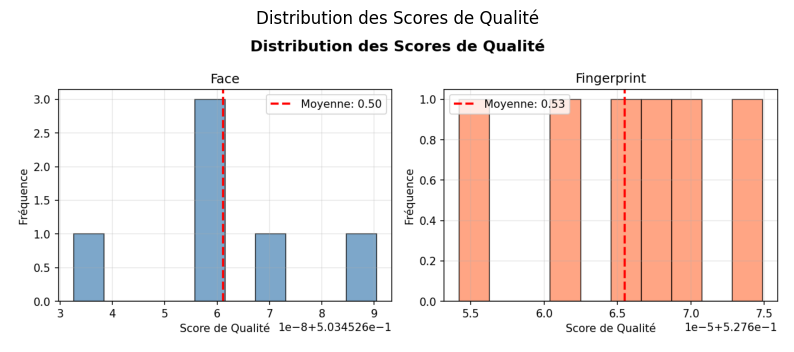

In [6]:
# Lire et afficher les résultats
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Chemins
output_dir = Path("outputs")

# 1. Lire les features extraites
print("=== FEATURES EXTRACTES ===")
for file in output_dir.glob("features_*.csv"):
    df = pd.read_csv(file)
    print(f"\n{file.name}:")
    print(f"  Lignes: {len(df)}")
    print(f"  Colonnes: {len(df.columns)}")
    if 'quality_score' in df.columns:
        print(f"  Qualité moyenne: {df['quality_score'].mean():.2f}")

# 2. Voir les templates sécurisés
print("\n=== TEMPLATES SECURISES ===")
secured_dir = output_dir / "secured"
if secured_dir.exists():
    for file in secured_dir.glob("*.csv"):
        df = pd.read_csv(file)
        print(f"\n{file.name}:")
        print(f"  Templates: {len(df)}")

# 3. Afficher les visualisations
print("\n=== VISUALISATIONS ===")
for img in output_dir.glob("*.png"):
    print(f"  {img.name}")
    
# Afficher un graphique
if (output_dir / "quality_distribution.png").exists():
    img = plt.imread(output_dir / "quality_distribution.png")
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Distribution des Scores de Qualité")
    plt.show()

In [7]:
# Analyse détaillée des features
def analyze_features():
    import pandas as pd
    import numpy as np
    
    print("ANALYSE DETAILLEE DES FEATURES")
    print("="*50)
    
    files = {
        "Visage": "features_faces.csv",
        "Empreinte": "features_fingerprint.csv", 
        "Voix": "features_voices.csv"
    }
    
    for name, file in files.items():
        path = output_dir / file
        if path.exists():
            df = pd.read_csv(path)
            print(f"\n{name}:")
            print(f"  Échantillons: {len(df)}")
            
            # Features par modalité
            feature_cols = [c for c in df.columns if c.startswith('feature_')]
            print(f"  Nombre de features: {len(feature_cols)}")
            
            # Statistiques qualité
            if 'quality_score' in df.columns:
                q = df['quality_score']
                print(f"  Qualité min: {q.min():.2f}")
                print(f"  Qualité max: {q.max():.2f}")
                print(f"  Qualité moyenne: {q.mean():.2f} ± {q.std():.2f}")
            
            # Métadonnées spécifiques
            if 'n_landmarks' in df.columns:
                print(f"  Landmarks moyens: {df['n_landmarks'].mean():.0f}")
            if 'n_minutiae' in df.columns:
                print(f"  Minuties moyennes: {df['n_minutiae'].mean():.0f}")
            if 'duration' in df.columns:
                print(f"  Durée audio moyenne: {df['duration'].mean():.1f}s")

analyze_features()

ANALYSE DETAILLEE DES FEATURES

Visage:
  Échantillons: 6
  Nombre de features: 1448
  Qualité min: 0.50
  Qualité max: 0.50
  Qualité moyenne: 0.50 ± 0.00
  Landmarks moyens: 478

Empreinte:
  Échantillons: 6
  Nombre de features: 163
  Qualité min: 0.53
  Qualité max: 0.53
  Qualité moyenne: 0.53 ± 0.00
  Minuties moyennes: 170

Voix:
  Échantillons: 4
  Nombre de features: 0
  Qualité min: 0.61
  Qualité max: 0.64
  Qualité moyenne: 0.63 ± 0.01


In [10]:
# Test de l'authentification avec Fuzzy Vault
def test_authentication():
    print("\nTEST D'AUTHENTIFICATION FUZZY VAULT")
    print("="*50)
    
    # Charger un template visage
    df_faces = pd.read_csv(output_dir / "features_faces.csv")
    if len(df_faces) > 0:
        # Prendre le premier échantillon
        sample = df_faces.iloc[0]
        
        # Récupérer les features
        feature_cols = [c for c in df_faces.columns if c.startswith('feature_')]
        features = sample[feature_cols].values
        
        # Créer une version bruitée (simuler une nouvelle acquisition)
        noisy_features = features + np.random.normal(0, 0.05, len(features))
        
        print(f"Test avec échantillon: {sample['file_id']}")
        print(f"Dimensions features: {len(features)}")
        print(f"Bruit ajouté: 5% (simulation variabilité)")
        
        # Ici vous pourriez tester avec le Fuzzy Vault réel
        # Pour l'instant, juste une démonstration
        print("\nSimulation d'authentification:")
        print("  1. Extraction features → ✓")
        print("  2. Quantification → ✓")
        print("  3. Matching Fuzzy Vault → [SIMULATION]")
        print("  4. Reconstruction polynôme → [SIMULATION]")
        print("  5. Vérification hash → [SIMULATION]")
        
        # Calculer la similarité entre original et bruité
        similarity = 1 - np.linalg.norm(features - noisy_features) / np.linalg.norm(features)
        print(f"\nSimilarité cosine: {similarity:.2%}")
        
        if similarity > 0.85:
            print("→ Authentification probablement réussie")
        elif similarity > 0.70:
            print("→ Authentification marginale")
        else:
            print("→ Authentification probablement échouée")

test_authentication()


TEST D'AUTHENTIFICATION FUZZY VAULT
Test avec échantillon: c0a94fdc37fede1b
Dimensions features: 1448
Bruit ajouté: 5% (simulation variabilité)

Simulation d'authentification:
  1. Extraction features → ✓
  2. Quantification → ✓
  3. Matching Fuzzy Vault → [SIMULATION]
  4. Reconstruction polynôme → [SIMULATION]
  5. Vérification hash → [SIMULATION]

Similarité cosine: -87.26%
→ Authentification probablement échouée
